In [1]:
import pandas as pd
import random
import numpy as np
import torch
from numpy import nan
import math
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

from sklearn import metrics

In [2]:
df = pd.read_csv('/Users/allan/Desktop/GRU_D_EWS/Data/ews_synthetic_data.csv')
df

,episode_id,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow,outcome_in_24hrs
0,2000.0,382.0,120.0,76.0,47.0,37.574380,8.0,100.0,1.0,True
1,2000.0,497.0,79.0,56.0,105.0,37.999197,14.0,97.0,6.0,True
2,2000.0,621.0,81.0,61.0,113.0,38.539351,9.0,98.0,6.0,True
3,2000.0,726.0,96.0,76.0,106.0,38.026928,17.0,97.0,5.0,True
4,2000.0,851.0,92.0,76.0,101.0,37.813805,13.0,100.0,6.0,True
...,...,...,...,...,...,...,...,...,...,...
47120,2999.0,688.0,111.0,67.0,53.0,38.488368,9.0,100.0,0.0,False
47121,2999.0,1050.0,113.0,76.0,42.0,36.415452,12.0,99.0,1.0,False
47122,2999.0,1443.0,118.0,78.0,51.0,37.414629,6.0,99.0,0.0,False
47123,2999.0,1820.0,128.0,86.0,45.0,37.972787,5.0,99.0,2.0,False


In [3]:
df['rr'][(df['rr'] < 1)]  = 5

/var/folders/tc/prmkt2fj0sq_z_h6cdpq8xsh0000gn/T/ipykernel_7098/4180768450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rr'][(df['rr'] < 1)]  = 5


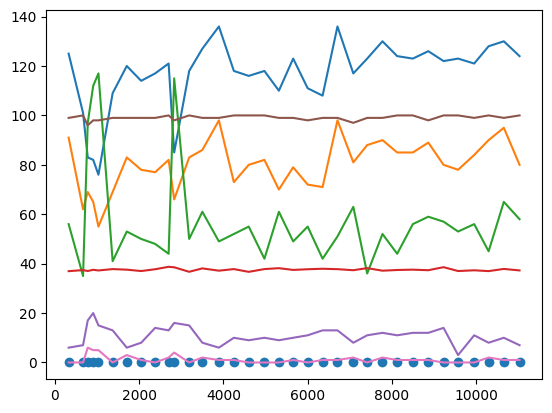

In [4]:
data = df[df['episode_id'] == 2878]

plt.plot(data['anchor_time'], data['sbp'])
plt.plot(data['anchor_time'], data['dbp'])
plt.plot(data['anchor_time'], data['hr'])
plt.plot(data['anchor_time'], data['temp'])
plt.plot(data['anchor_time'], data['rr'])
plt.plot(data['anchor_time'], data['spo2'])
plt.plot(data['anchor_time'], data['flow'])

plt.scatter(data['anchor_time'], data['outcome_in_24hrs']*175)
# plt.legend(cols[1:])


In [5]:
len(data)

34

In [6]:
from pre_processing_func import *



In [9]:
cols =[ 'anchor_time',	'sbp',	'dbp',	'hr',	'temp',	'rr',	'spo2',	'flow']


def train_val_test_split(data, labels, train_prop = 0.7, val_prop = 0.1, test_val = 0.2):
    
    assert train_prop + val_prop + test_val == 1, 'Proportions must = 1'

    sample_size = data.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.seed(1024) # If crossval - This would need to change
    np.random.shuffle(index)
    
    data = data[index]
    
    labels = labels[index]
    
    # Get indices of when training/validation/test split    
    train_index = int(np.floor(sample_size * train_prop))
    valid_index = int(np.floor(sample_size * ( train_prop + val_prop)))
    
    train_data, train_label = data[:train_index], labels[:train_index] 
    valid_data, valid_label = data[train_index:valid_index], labels[train_index:valid_index]
    test_data, test_label = data[valid_index:], labels[valid_index:]

    return train_data, train_label, valid_data, valid_label, test_data, test_label , index[valid_index:]

def df_to_np_pipe (df,cols, time_steps_req):
    '''
    Takes df with vital signs and returns an np.array of data and array of episode order
    Input: DF (Spell, Time_step, Vitals signs....), number of time steps required
    Returns: np.array (Batch, Time_step, Features)
    Feature order: Time_lag, RR, SBP, DBP, HR, Temp, Spo2
    '''
    # Batch, seq_len, features
    episodes = df['episode_id'].unique()
    
    X = np.zeros((len(episodes), time_steps_req, len(cols)))

    Y = -np.ones((len(episodes), time_steps_req))

    id = 0
    for epi in episodes:
        data = (df[df['episode_id'] == epi]).reset_index() # Reset so you can directly index
        length = len(data)
        # If spell has less than required, add available data to beginning of array
        #Using Loc you have to directly index rather than reverse slice
        if length < time_steps_req:
            X[id,:length,:] = data.loc[0:length, cols].to_numpy()
            Y[id,:length] = data.loc[0:length, 'outcome_in_24hrs'].to_numpy()
            id += 1
        # If spell has more than required, last x time_steps of spell goes to data
        else:
            X[id,:,:] = data.loc[length-time_steps_req:length, cols].to_numpy()
            Y[id,:] = data.loc[length-time_steps_req:length, 'outcome_in_24hrs'].to_numpy()
            id += 1
    
    return X, Y, episodes

X, Y, episodes = df_to_np_pipe(df,cols,200)

In [10]:
train_data, train_label, valid_data, valid_label, test_data, test_label, test_idx= train_val_test_split(X, Y)
print ('Train Length', len(train_data), 'Event rate:', train_label.max(axis=1).sum()/len(train_label))
print ('Val Length', len(valid_data), 'Event rate:', valid_label.max(axis=1).sum()/len(valid_label))
print ('Test Length', len(test_data), 'Event rate:', test_label.max(axis=1).sum()/len(test_label))

Train Length 700 Event rate: 0.2042857142857143
Val Length 99 Event rate: 0.2222222222222222
Test Length 201 Event rate: 0.17412935323383086


In [8]:
valid_label

array([[ 0.,  0.,  0., ..., -1., -1., -1.],
       [ 0.,  0.,  0., ..., -1., -1., -1.],
       [ 0.,  0.,  0., ..., -1., -1., -1.],
       ...,
       [ 0.,  0.,  0., ..., -1., -1., -1.],
       [ 0.,  0.,  0., ..., -1., -1., -1.],
       [ 0.,  0.,  0., ..., -1., -1., -1.]])

In [11]:
from pre_processing_func import *

gru_train_x, gru_train_len, gru_train_timings, X_mean, train_means, train_std, max_delta  = train_mask_delta_generator(train_data)
gru_val_x, gru_val_len, gru_val_timings = val_test_mask_delta_generator(valid_data,train_means, train_std, max_delta)

# gru_val_x, gru_val_len, gru_val_timings  = val_test_mask_delta_generator(valid_data, train_means, train_std, max_delta)
# gru_test_x, gru_test_len, gru_test_timings = val_test_mask_delta_generator(test_data,   train_means, train_std, max_delta)


Start to generate Mask, Delta, Last_observed_X ...
Finished
Start to generate Mask, Delta, Last_observed_X ...
Finished


In [12]:
gru_test_x, gru_test_len, gru_test_timings = val_test_mask_delta_generator(test_data,train_means, train_std, max_delta)

Start to generate Mask, Delta, Last_observed_X ...
Finished


In [11]:
def val_test_mask_delta_generator (data, train_means, train_std, max_delta):
    ''' Normalises and generates masks required for decay learning
    Learns parameters for normalisation and passes on to val_test generator
    Takes: data array (Sample, Time_Step, Feature), 
    train_means, train_std, max_delta - parameters from training for normalisation 
    Returns 
    Model input(Sample, model input(4), time_step, feature)
    Length: Array seq_len for trimming (sample)
    '''
    print('Start to generate Mask, Delta, Last_observed_X ...')

    flow = data[:,:,7]
    data[:,:,7][flow == 0] = 0.1
    data[data == 0] = np.nan
    X = data[:,:,1:].round()

    # Where there is no observation 
    Mask = (X != -1)    
    # Normalise data to training ranges
    X = (X - train_means) / train_std
    
    # Get lags from first index
    lags = np.diff(data[:,:,0])
    # Alter the anchor_time to time_lags
    time_lags = data[:,:,0]
    time_lags[:,1:] = lags


    # Find the lengths of each time series
    
    lengths =  (~np.isnan(time_lags)).sum(axis = 1)
    

    # # Time_lags is S vector in paper -> Contains time lags of all examples (N x Time_steps)
    # time_lags = np.zeros((data.shape[0],data.shape[1]))
    # # Get lags from first index
    # time_lags[:,1:] = data[:,1:,0]

    Delta = np.repeat(time_lags, X.shape[2], axis=1) # Like np.tile
    Delta = np.reshape(Delta, X.shape) # Reshape into data matrix shape
    
    X_last_obsv = np.copy(X)
    # Get the idx access
    missing_index = np.where(Mask == 0)
    # I: batch, j: time_step, k: feature
    for idx in range(missing_index[0].shape[0]):
        # Selects where there is a missing according to mask
        i = missing_index[0][idx] 
        j = missing_index[1][idx]
        k = missing_index[2][idx]
            # If previous not missing then delta = current time lag last observed + previous
        if j != 0 and j != (X.shape[1]-1): # This logic is to avoid first and last! need to alter j needs to be time step
            Delta[i,j+1,k] = Delta[i,j+1,k] + Delta[i,j,k]
        if j != 0:
            X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] # last observation
    # normalize - currently max/min scaled keeps 0-1
    Delta = Delta / max_delta

    X = np.expand_dims(X, axis=1)
    X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
    Mask = np.expand_dims(Mask, axis=1)
    Delta = np.expand_dims(Delta, axis=1)
    dataset_agger = np.concatenate((X, X_last_obsv, Mask, Delta), axis = 1)

    print('Finished')
    
    return dataset_agger , lengths,  np.cumsum(time_lags, axis = 1)

In [13]:
def dataset_compiler_gru_shorten (data, labels, lengths, timings):
    '''
    Removes instances where there are not enough observations
    Trims each instance based on the length of admission from the mask_generator

    Takes: Data array, label array, length array, timings (anchor_time)
    Returns: Dataset
    '''
    # Exclude instances < 24hrs (1440 mins)
    inclusion_mask = np.nanmax(timings, axis = 1) >=1440
    data = data[inclusion_mask]
    labels = labels[inclusion_mask]
    lengths = lengths[inclusion_mask]
    timings = timings[inclusion_mask]

    # Find the time_steps within 48hrs of end of admission (2880 min)
    threshold_48 = np.nanmax(timings, axis = 1) - 2880
    within_48 = (timings) > threshold_48[:,np.newaxis]
    # First index within 48hrs
    indices_48 = np.where(within_48.any(axis=1), within_48.argmax(axis=1), -1)
    
    # Holding list to capture incoming tensors
    X = []
    y = []
    # Iteratrates through length array and trims data array in the time_step dim

    for id in range(len(data)):
        start = int(indices_48 [id])
        end = int(lengths [id])
        X.append(torch.Tensor(data[id,:,start:end,:]))
        y.append(torch.Tensor(labels[id,start:end]))

    # Combines list of tensors and labels
    dataset = CustomDataset(X, y)

    return  dataset

def dataset_compiler_gru(data, labels, lengths, timings):
    '''
    Removes instances where there are not enough observations
    Trims each instance based on the lengths from the mask_generator
    Use this for the test set to give representive sample of the real world (i.e. throughout the admission)

    Takes: Data array, label array, length array, , timings (anchor_time)
    Returns: Dataset
    '''
    # Exclude instances < 24hrs (1440 mins)
    inclusion_mask = np.nanmax(timings, axis = 1) >=1440
    data = data[inclusion_mask]
    labels = labels[inclusion_mask]
    lengths = lengths[inclusion_mask]
    timings = timings[inclusion_mask]
    
    
    # Holding list to capture incoming tensors
    X = []
    y = []
    # Iteratrates through length array and trims data array in the time_step dim
    # id = 0
    for id in range(len(data)):
        end = int(lengths [id])
        X.append(torch.Tensor(data[id,:,:end,:]))
        y.append(torch.Tensor(labels[id,:end]))

    # Combines list of tensors and labels
    dataset = CustomDataset(X, y)

    return dataset

In [14]:
gru_train_timings

array([[ 375.,  734., 1117., ...,   nan,   nan,   nan],
       [ 350.,  720., 1096., ...,   nan,   nan,   nan],
       [ 353.,  716., 1056., ...,   nan,   nan,   nan],
       ...,
       [ 363.,  760., 1112., ...,   nan,   nan,   nan],
       [ 355.,  721., 1078., ...,   nan,   nan,   nan],
       [ 348.,  738., 1119., ...,   nan,   nan,   nan]])

In [19]:
gru_train_dataset = dataset_compiler_gru_shorten(gru_train_x, train_label, gru_train_len, gru_train_timings)
gru_val_dataset = dataset_compiler_gru_shorten(gru_val_x, valid_label, gru_val_len, gru_val_timings)
gru_test_dataset  = dataset_compiler_gru(gru_test_x, test_label, gru_test_len, gru_test_timings)


gru_train_dataloader = dataloader_compiler (gru_train_dataset, batch_size = 20)
gru_val_dataloader = dataloader_compiler (gru_val_dataset, batch_size = 1)

# Testing allows for assessment per patient
gru_test_dataloader = DataLoader(gru_test_dataset, batch_size= 1, shuffle= False)

In [118]:
np.where(np.isnan(np.stack(a).squeeze()))

(array([ 419,  420, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669,
        1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680,
        1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691,
        1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702,
        1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713,
        1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724,
        1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735,
        1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746,
        1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757,
        1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768,
        1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779,
        1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790,
        1791, 1792, 1793, 1794, 1795, 1796, 5807, 5808, 5809, 5810, 5811,
        5812, 5813, 7173, 7174, 7175, 

In [205]:
np.where(b.cumsum() <7173)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]),)

In [168]:
X, y ,dataset_idx, gru_test_dataset  = dataset_compiler_gru(gru_test_x, test_label, gru_test_len, gru_test_timings, test_idx)


In [166]:
len(gru_test_dataset)

179

In [170]:
dataset_idx.shape

(179,)

In [185]:
(gru_test_x[112][0]).shape

(200, 7)

In [206]:
np.where(np.isnan(np.stack(X[142][0])))

(array([53]), array([4]))

In [208]:
episodes[404]

2404.0

In [207]:
dataset_idx[142]

404

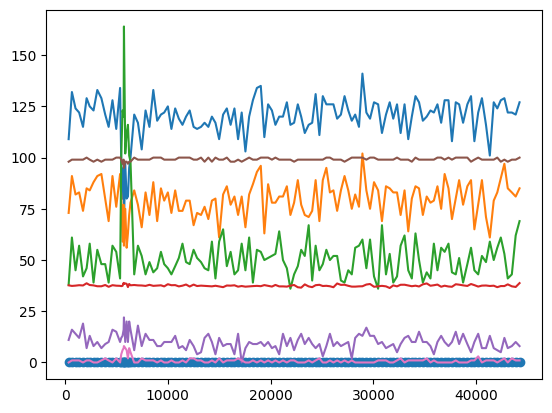

In [209]:
data = df[df['episode_id'] == 2404]

plt.plot(data['anchor_time'], data['sbp'])
plt.plot(data['anchor_time'], data['dbp'])
plt.plot(data['anchor_time'], data['hr'])
plt.plot(data['anchor_time'], data['temp'])
plt.plot(data['anchor_time'], data['rr'])
plt.plot(data['anchor_time'], data['spo2'])
plt.plot(data['anchor_time'], data['flow'])

plt.scatter(data['anchor_time'], data['outcome_in_24hrs']*175)
# plt.legend(cols[1:])


In [15]:
df.describe()

,episode_id,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow
count,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000,47125.000000
mean,2463.964541,11280.745549,105.149899,74.001528,77.556477,37.638715,12.472743,98.400531,2.725050
std,301.927449,10510.218921,21.733844,12.170467,37.093601,0.514832,4.551505,1.756389,2.916729
min,2000.000000,91.000000,37.000000,25.000000,23.000000,35.447830,1.000000,87.000000,0.000000
25%,2181.000000,3439.000000,90.000000,68.000000,48.000000,37.294358,9.000000,98.000000,1.000000
50%,2445.000000,8186.000000,114.000000,76.000000,56.000000,37.620647,12.000000,99.000000,1.000000
75%,2729.000000,15805.000000,122.000000,82.000000,110.000000,37.962782,15.000000,100.000000,5.000000
max,2999.000000,64107.000000,149.000000,111.000000,177.000000,41.051724,31.000000,100.000000,16.000000


In [211]:
data.head(55)

,episode_id,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow,outcome_in_24hrs
21658,2404.0,348.0,109.0,73.0,38.0,37.653713,11.0,98.0,0.0,False
21659,2404.0,666.0,132.0,91.0,61.0,37.364459,16.0,99.0,1.0,False
21660,2404.0,1018.0,124.0,82.0,45.0,37.505426,14.0,99.0,1.0,False
21661,2404.0,1369.0,122.0,83.0,57.0,37.715150,12.0,99.0,1.0,False
21662,2404.0,1746.0,115.0,74.0,42.0,37.588149,19.0,99.0,0.0,False
21663,2404.0,2096.0,129.0,85.0,46.0,38.654649,7.0,100.0,1.0,False
21664,2404.0,2398.0,125.0,84.0,58.0,37.805069,13.0,99.0,1.0,False
21665,2404.0,2770.0,123.0,88.0,39.0,37.627925,8.0,98.0,0.0,False
21666,2404.0,3137.0,133.0,91.0,55.0,37.209903,10.0,99.0,0.0,False
21667,2404.0,3534.0,129.0,92.0,48.0,37.194972,7.0,98.0,1.0,False


In [16]:

def Train_Binary_Model(model, train_dataloader, valid_dataloader, num_epochs = 300, patience = 10, min_delta = 0.00001, learning_rate = 0.00001):
    
    print('Model Structure: ', model)
    print('Start Training ... ')
    
    if (type(model) == nn.modules.container.Sequential):
        output_last = model[-1].output_last
        print('Output type dermined by the last layer')
    else:
        output_last = model.output_last
        print('Output type dermined by the model')
        
    loss_MSE = torch.nn.BCELoss()    
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    use_gpu = torch.cuda.is_available()
    if use_gpu == False:
        device = 'cpu'

    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []
    
    cur_time = time.time()
    pre_time = time.time()
    
    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0
    for epoch in range(num_epochs):
        
        trained_number = 0
       
        valid_dataloader_iter = iter(valid_dataloader)
        
        losses_epoch_train = []
        losses_epoch_valid = []
        
        for data in train_dataloader:
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else: 
                inputs, labels = inputs.to(device), labels.to(device)
            
            model.zero_grad()

            outputs = model(inputs)
            
            loss_train = loss_MSE(torch.squeeze(outputs), torch.squeeze(labels))
           
            losses_train.append(loss_train.data)
            losses_epoch_train.append(loss_train.data)
            
            optimizer.zero_grad()
            
            loss_train.backward()
            
            optimizer.step()
            
             # validation 
            try: 
                inputs_val, labels_val = next(valid_dataloader_iter)
            except StopIteration:
                valid_dataloader_iter = iter(valid_dataloader)
                inputs_val, labels_val = next(valid_dataloader_iter)
            
            if use_gpu:
                inputs_val, labels_val = inputs_val.cuda(), labels_val.cuda()
            else: 
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            

            model.zero_grad()
            
            outputs_val = model(inputs_val)
         
            loss_valid = loss_MSE(torch.squeeze(outputs_val), torch.squeeze(labels_val))
            
            losses_valid.append(loss_valid.data)
            losses_epoch_valid.append(loss_valid.data)
            
            # output
            trained_number += 1
            
        avg_losses_epoch_train = sum(losses_epoch_train).cpu().numpy() / float(len(losses_epoch_train))
        avg_losses_epoch_valid = sum(losses_epoch_valid).cpu().numpy() / float(len(losses_epoch_valid))
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)
        
        # Early Stopping
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = 10000.0
            if avg_losses_epoch_valid < min_loss_epoch_valid:
                min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid 
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print('Early Stopped at Epoch:', epoch)
                    break
        
        # Print training parameters
        cur_time = time.time()
        print('Epoch: {}, train_loss: {}, valid_loss: {}, time: {}, best model: {}'.format( \
                    epoch, \
                    np.around(avg_losses_epoch_train, decimals=8),\
                    np.around(avg_losses_epoch_valid, decimals=8),\
                    np.around([cur_time - pre_time] , decimals=2),\
                    is_best_model) )
        pre_time = cur_time
                
    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]


In [18]:
def collate_function(batch):
    '''Takes batch and pads to max seq_len within the batch
    '''
    inputs, labels = zip(*batch)
    max_length = max(matrix.size(1) for matrix in inputs)
    padded_inputs =  [torch.nn.functional.pad(matrix, (0, 0, 0, max_length - matrix.size(1))) for matrix in inputs]
    inputs = torch.stack(padded_inputs)
    inputs = torch.nan_to_num(inputs, nan = 0.0)

    max_label_length = max(len(label) for label in labels)
    padded_labels = [np.pad(label, (0, max_label_length - len(label)), 'constant') for label in labels]
    stacked_labels = np.stack((padded_labels))
    
    return inputs, torch.Tensor(stacked_labels)

def dataloader_compiler (dataset, batch_size = 20):
    sampler = SortByLengthSampler(dataset, batch_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        collate_fn=collate_function, 
                        sampler=sampler)
    
    return dataloader



In [58]:
id =0
from GRUD import *
gru_d = GRUD(7,24,X_mean,2)
for data in gru_train_dataloader:
            inputs, labels = data
            print('outputs: ', gru_d(inputs).shape)
            print('labels', labels)
            


outputs:  torch.Size([20, 34, 1])
labels tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 

In [20]:
from GRUD import *
# from train_test_func import Train_Binary_Model

gru_d = GRUD(7,24,X_mean,2)

mod, stats = Train_Binary_Model(gru_d, gru_train_dataloader, gru_val_dataloader,patience = 20, min_delta = 0.0002, learning_rate=0.0002)

Model Structure:  GRUD(
  (zl): Linear(in_features=38, out_features=24, bias=True)
  (rl): Linear(in_features=38, out_features=24, bias=True)
  (hl): Linear(in_features=38, out_features=24, bias=True)
  (gamma_x_l): FilterLinear(in_features=7, out_features=7, bias=True)
  (gamma_h_l): Linear(in_features=7, out_features=24, bias=True)
  (binary_final_fcl): Linear(in_features=24, out_features=1, bias=True)
  (multi_final_fcl): Linear(in_features=24, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)
Start Training ... 
Output type dermined by the model
Epoch: 0, train_loss: 0.82209677, valid_loss: 0.82987952, time: [0.36], best model: 1
Epoch: 1, train_loss: 0.7531513, valid_loss: 0.76378012, time: [0.32], best model: 1
Epoch: 2, train_loss: 0.68907171, valid_loss: 0.68517786, time: [0.31], best model: 1
Epoch: 3, train_loss: 0.61863089, valid_loss: 0.62493026, time: [0.29], best model: 1
Epoch: 4, train_loss: 0.56098008, valid_loss: 0.53826517, time: [0.34], best model: 1
Epoch: 5, tra

Text(0.5, 1.0, 'Loss Pattern during GRU-D Training')

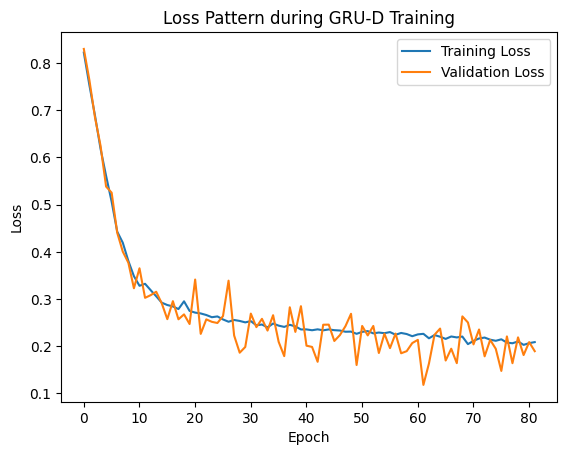

In [45]:
plt.plot(range(len(stats[2])),stats[2], label = 'Training Loss')
plt.plot(range(len(stats[2])),stats[3], label = 'Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss Pattern during GRU-D Training' )

In [42]:

def Test_Binary_Model(model, test_dataloader, title, classes = ['Survived', 'Died']):
    
    if (type(model) == nn.modules.container.Sequential):
        output_last = model[-1].output_last
    else:
        output_last = model.output_last
    
    inputs, labels = next(iter(test_dataloader))
    batch_size= inputs.size(0)

    cur_time = time.time()
    pre_time = time.time()
    
    use_gpu = torch.cuda.is_available()
    if use_gpu == False:
        device = 'cpu'
    
    tested_batch = 0
    
    prob_out = []
    lengths = []
    ground_truth = []
    pred = []

    print("Testing Loop")
   
    model.eval()
    with torch.no_grad():    
        for data in test_dataloader:
            inputs, labels = data
            ground_truth.extend(labels)
            lengths.append(labels.size(1))
            if inputs.shape[0] != batch_size:
                continue
        
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else: 
                inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            prob_out.extend(outputs)
            loss_BSE = torch.nn.BCELoss()

            if output_last:
                predictions = torch.round(outputs)
                pred.extend(predictions)
          
                
            else:
                predictions = torch.round(outputs)
                pred.extend(predictions)
            
            tested_batch += 1
        
            if tested_batch % 1000 == 0:
                cur_time = time.time()
                print('Tested #: {}, time: {}'.format( \
                    tested_batch * batch_size, \

                    np.around([cur_time - pre_time], decimals=8) ) )
                pre_time = cur_time
    
    print('Plotting Matrix')
    # Consolidate lists
    ground_truth = [item for sublist in ground_truth for item in sublist]
    prob_out = [item for sublist in prob_out for item in sublist]
    pred = [item for sublist in pred for item in sublist]

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(np.stack(ground_truth), np.row_stack(pred))
    # Calculate the percentage of each class in the confusion matrix
    conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure()
    sns.heatmap(conf_matrix_percent, annot=conf_matrix, fmt='d', cmap='Blues', vmin=0, vmax=1)
    plt.xlabel('Predicted Label',fontsize=20)
    plt.ylabel('True Label',fontsize=20)    
    plt.yticks(np.arange(len(classes)) + 0.5, classes , rotation=45,fontsize=10)
    plt.xticks(np.arange(len(classes)) + 0.5, classes ,fontsize=10)
    plt.title(title ,fontsize=20)
    plt.show()

    acc = np.diag(conf_matrix).sum()/conf_matrix.sum()
    precision=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
    spec = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    recall=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
    bal_acc = (spec+recall)/2 

    print(f'Accuracy : {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Specificity: {spec:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')

    ground_truth = torch.stack(ground_truth)
    prob_out = torch.stack(prob_out).squeeze()
    print('Plotting ROC Curves')
    # Calcuations for AUC plots
    # ROC and PRC thresholds
    fpr, tpr, _ = roc_curve(ground_truth, prob_out)
    precis, rec, _ = precision_recall_curve(ground_truth,prob_out)
    print(f'AUROC: {auc(fpr, tpr):.4f}')
    print(f'AUPRC: {auc(rec, precis):.4f}')

    

    # AUROC Plot
    plt.plot(fpr, tpr, marker='o',linestyle='-', label=title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for '+ title)
    plt.legend()
    plt.show()

    #AUPRC Plot
    plt.plot(rec, precis, marker='o',linestyle='-', label=title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PRC for '+ title)
    plt.legend()
    plt.show()

    return prob_out, np.array(lengths), pred, ground_truth

def plot_confusion_matrix(cm, labels, normalize= False, title="Confusion Matrix"):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    #plt.xticks(tick_marks, labels, rotation=45)
    #plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Testing Loop
Plotting Matrix


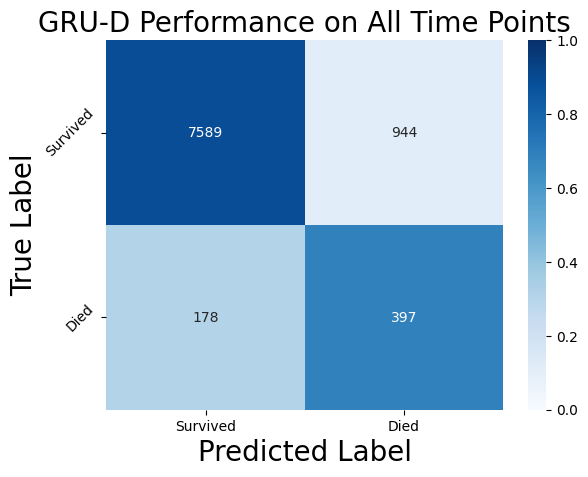

Accuracy : 0.8768
Precision: 0.2960
Specificity: 0.8894
Recall: 0.6904
Balanced Accuracy: 0.7899
Plotting ROC Curves
AUROC: 0.9062
AUPRC: 0.4220


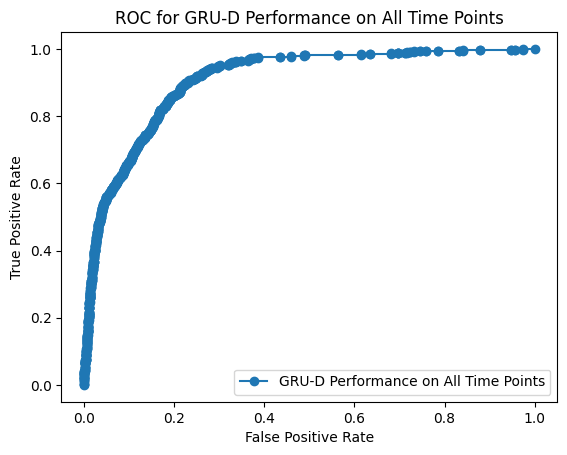

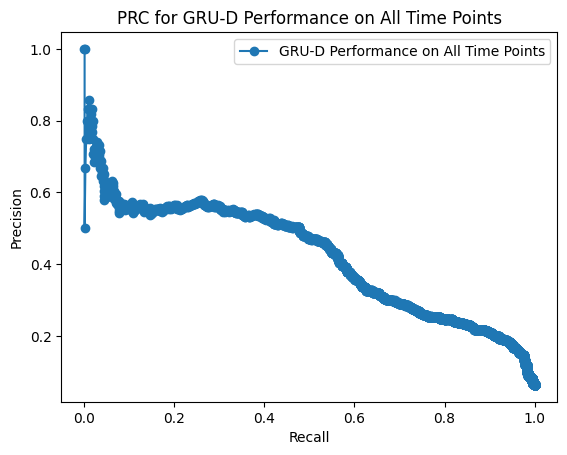

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

a,b,c,d = Test_Binary_Model(mod, gru_test_dataloader, 'GRU-D Performance on All Time Points', classes = ['Survived', 'Died'])
    

In [34]:
np.isnan(np.stack(c).squeeze())

array([False, False, False, ..., False, False, False])

In [96]:
np.stack(d).shape

(9108,)

In [37]:
d.shape

AttributeError: 'list' object has no attribute 'shape'

In [38]:
confusion_matrix(np.stack(c), np.stack(d))

array([[7589,  178],
       [ 944,  397]])